# IIC-3800 Tópicos en CC - NLP UC

- Versiones de librerías, python 3.8.10

- numpy 1.23.5
- keras 2.9.0
- tensorflow 2.9.1
- tensorflow_datasets 4.9.2
- tensorflow_text 2.12.0


In [1]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/es_to_pt', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/44938 [00:00<?, ? examples/s]

Shuffling /home/marcelo/tensorflow_datasets/ted_hrlr_translate/es_to_pt/1.0.0.incompleteOYGYX6/ted_hrlr_transl…

Generating validation examples...:   0%|          | 0/1016 [00:00<?, ? examples/s]

Shuffling /home/marcelo/tensorflow_datasets/ted_hrlr_translate/es_to_pt/1.0.0.incompleteOYGYX6/ted_hrlr_transl…

Generating test examples...:   0%|          | 0/1763 [00:00<?, ? examples/s]

Shuffling /home/marcelo/tensorflow_datasets/ted_hrlr_translate/es_to_pt/1.0.0.incompleteOYGYX6/ted_hrlr_transl…

Dataset ted_hrlr_translate downloaded and prepared to /home/marcelo/tensorflow_datasets/ted_hrlr_translate/es_to_pt/1.0.0. Subsequent calls will reuse this data.


Ver mas datasets paralelos en: https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate?hl=es-419

In [4]:
train_examples, val_examples = examples['train'], examples['validation']

In [5]:


for es_examples, pt_examples in train_examples.batch(3).take(1):
  print('> Examples in Spanish:')
  for es in es_examples.numpy():
    print(es.decode('utf-8'))
  print()

  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

> Examples in Spanish:
`` la palabra es `` '' inadaptado '' '' . es una de mis palabras favoritas , porque es muy literal . ''
pero el problema real es la falta de otras infraestructuras .
y quiero compartir con uds mi último trabajo .

> Examples in Portuguese:
`` a palavra é `` '' desajustado '' '' . é uma das minhas palavras preferidas , por ser tão literal . ''
mas o verdadeiro problema é a falta de outras infraestruturas .
e quero partilhar convosco o meu último projecto artístico .


In [12]:
model_name = 'ted_hrlr_translate_pt_en_converter'

tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [13]:
tokenizers = tf.saved_model.load(model_name)

In [14]:
[item for item in dir(tokenizers.pt) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [15]:
print('> This is a batch of strings:')
for pt in pt_examples.numpy():
  print(pt.decode('utf-8'))

> This is a batch of strings:
`` a palavra é `` '' desajustado '' '' . é uma das minhas palavras preferidas , por ser tão literal . ''
mas o verdadeiro problema é a falta de outras infraestruturas .
e quero partilhar convosco o meu último projecto artístico .


In [16]:
encoded = tokenizers.pt.tokenize(pt_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 39, 39, 40, 577, 44, 39, 39, 9, 9, 83, 612, 5042, 1086, 1058, 9, 9, 9, 9, 16, 44, 86, 124, 549, 354, 5271, 14, 101, 117, 194, 2689, 5085, 16, 9, 9, 3]
[2, 99, 54, 1461, 231, 44, 40, 1138, 83, 264, 4429, 16, 3]
[2, 44, 229, 749, 1404, 54, 142, 796, 1145, 5450, 16, 3]


In [17]:
round_trip = tokenizers.pt.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
` ` a palavra e ` ` ' ' desajustado ' ' ' ' . e uma das minhas palavras preferidas , por ser tao literal . ' '
mas o verdadeiro problema e a falta de outras infraestruturas .
e quero partilhar convosco o meu ultimo projecto artistico .


In [18]:
print('> This is the text split into tokens:')
tokens = tokenizers.pt.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'`', b'`', b'a', b'palavra', b'e', b'`', b'`', b"'", b"'",
  b'de', b'##sa', b'##j', b'##us', b'##tado', b"'", b"'", b"'", b"'", b'.',
  b'e', b'uma', b'das', b'minhas', b'palavras', b'preferidas', b',', b'por',
  b'ser', b'tao', b'li', b'##teral', b'.', b"'", b"'", b'[END]']            ,
 [b'[START]', b'mas', b'o', b'verdadeiro', b'problema', b'e', b'a',
  b'falta', b'de', b'outras', b'infraestruturas', b'.', b'[END]']  ,
 [b'[START]', b'e', b'quero', b'partilhar', b'convosco', b'o', b'meu',
  b'ultimo', b'projecto', b'artistico', b'.', b'[END]']               ]>

In [22]:
lengths = []

for es_examples, pt_examples in train_examples.batch(1024):
  es_tokens = tokenizers.pt.tokenize(es_examples)
  lengths.append(es_tokens.row_lengths())
  
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

In [23]:
all_lengths = np.concatenate(lengths)
max_length = max(all_lengths)

Text(0.5, 1.0, 'Maximum tokens per example: 284')

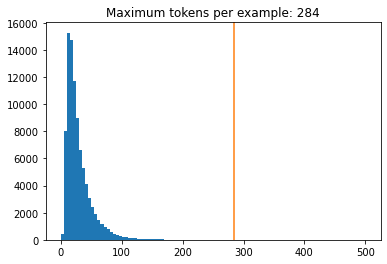

In [24]:
plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}')

In [25]:
MAX_TOKENS=128

def prepare_batch(es, pt):
    es = tokenizers.pt.tokenize(es)      # Output is ragged.
    es = es[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    es = es.to_tensor()  # Convert to 0-padded dense Tensor

    pt = tokenizers.pt.tokenize(pt)
    pt = pt[:, :(MAX_TOKENS+1)]
    pt_inputs = pt[:, :-1].to_tensor()  # Drop the [END] tokens
    pt_labels = pt[:, 1:].to_tensor()   # Drop the [START] tokens

    return (es, pt_inputs), pt_labels

In [26]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [27]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [28]:
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [30]:
print(pt[0][:10])
print(pt_labels[0][:10])

tf.Tensor([   2  122   14  568   84  175  130   41 7090 3054], shape=(10,), dtype=int64)
tf.Tensor([ 122   14  568   84  175  130   41 7090 3054  206], shape=(10,), dtype=int64)


In [33]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     
  depths = np.arange(depth)[np.newaxis, :]/depth   
  
  angle_rates = 1 / (10000**depths)         
  angle_rads = positions * angle_rates      

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 512)


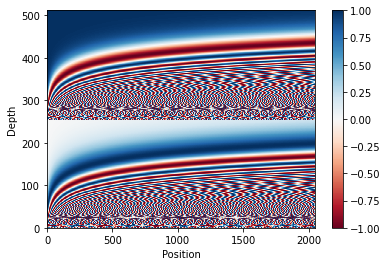

In [34]:
pos_encoding = positional_encoding(length=2048, depth=512)

print(pos_encoding.shape)

plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

(0.0, 1.0)

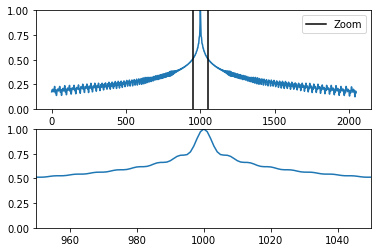

In [35]:
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

In [36]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [37]:
embed_es = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)

es_emb = embed_es(es)
pt_emb = embed_pt(pt)

In [38]:
pt_emb._keras_mask

<tf.Tensor: shape=(64, 65), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

In [40]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()
     

In [41]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [42]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(sample_ca(pt_emb, es_emb).shape)

(64, 65, 512)


In [43]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [44]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

In [45]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [47]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)
out1 = sample_csa(embed_pt(es[:, :3])) 
out2 = sample_csa(embed_pt(es))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

0.0

In [48]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [49]:
sample_ffn = FeedForward(512, 2048)

In [50]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [51]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

In [52]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x 

In [53]:
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(es, training=False)

In [54]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [55]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)
sample_decoder_layer_output = sample_decoder_layer(x=pt_emb, context=es_emb)

In [56]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [57]:
sample_decoder = Decoder(num_layers=4, d_model=512, num_heads=8, dff=2048, vocab_size=8000)
output = sample_decoder(x=pt, context=es_emb)

In [58]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    context, x  = inputs

    context = self.encoder(context)  

    x = self.decoder(x, context)  

    logits = self.final_layer(x)  

    try:
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [59]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [60]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [61]:
output = transformer((es, pt))

In [62]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores

In [63]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3632768   
                                                                 
 decoder_1 (Decoder)         multiple                  5743744   
                                                                 
 dense_38 (Dense)            multiple                  1001685   
                                                                 
Total params: 10,378,197
Trainable params: 10,378,197
Non-trainable params: 0
_________________________________________________________________


In [64]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [65]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

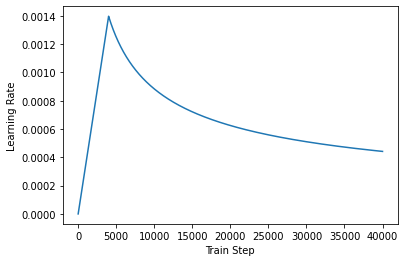

In [66]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [67]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [68]:
transformer.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])

In [69]:
transformer.fit(train_batches, epochs=10, validation_data=val_batches)

Epoch 1/10
703/703 [==============================] - 1143s 2s/step - loss: 7.0443 - masked_accuracy: 0.1192 - val_loss: 5.5632 - val_masked_accuracy: 0.1903
Epoch 2/10
703/703 [==============================] - 1106s 2s/step - loss: 5.1220 - masked_accuracy: 0.2307 - val_loss: 4.6813 - val_masked_accuracy: 0.2679
Epoch 3/10
703/703 [==============================] - 1099s 2s/step - loss: 4.4340 - masked_accuracy: 0.2911 - val_loss: 4.0761 - val_masked_accuracy: 0.3305
Epoch 4/10
703/703 [==============================] - 1091s 2s/step - loss: 3.9294 - masked_accuracy: 0.3398 - val_loss: 3.7444 - val_masked_accuracy: 0.3643
Epoch 5/10
703/703 [==============================] - 1093s 2s/step - loss: 3.5011 - masked_accuracy: 0.3877 - val_loss: 3.3022 - val_masked_accuracy: 0.4290
Epoch 6/10
703/703 [==============================] - 1195s 2s/step - loss: 3.1510 - masked_accuracy: 0.4319 - val_loss: 3.0736 - val_masked_accuracy: 0.4605
Epoch 7/10
703/703 [==============================] 

In [70]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    start_end = self.tokenizers.pt.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      predictions = predictions[:, -1:, :]

      predicted_id = tf.argmax(predictions, axis=-1)

      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.pt.detokenize(output)[0]

    tokens = tokenizers.pt.lookup(output)[0]
    
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [71]:
translator = Translator(tokenizers, transformer)

In [72]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [73]:
sentence = 'este es un problema que tenemos que resolver.'
ground_truth = 'este é um problema que temos que resolver.'

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))

print_translation(sentence, translated_text, ground_truth)

Input:         : este es un problema que tenemos que resolver.
Prediction     : este e um problema que temos de resolver .
Ground truth   : este é um problema que temos que resolver.


In [74]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [75]:
head = 0

attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]

In [76]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]

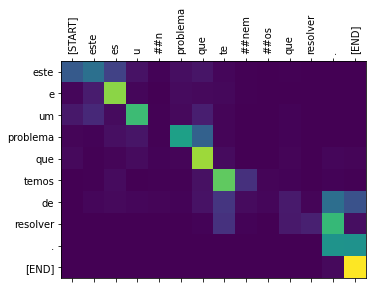

In [77]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [78]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

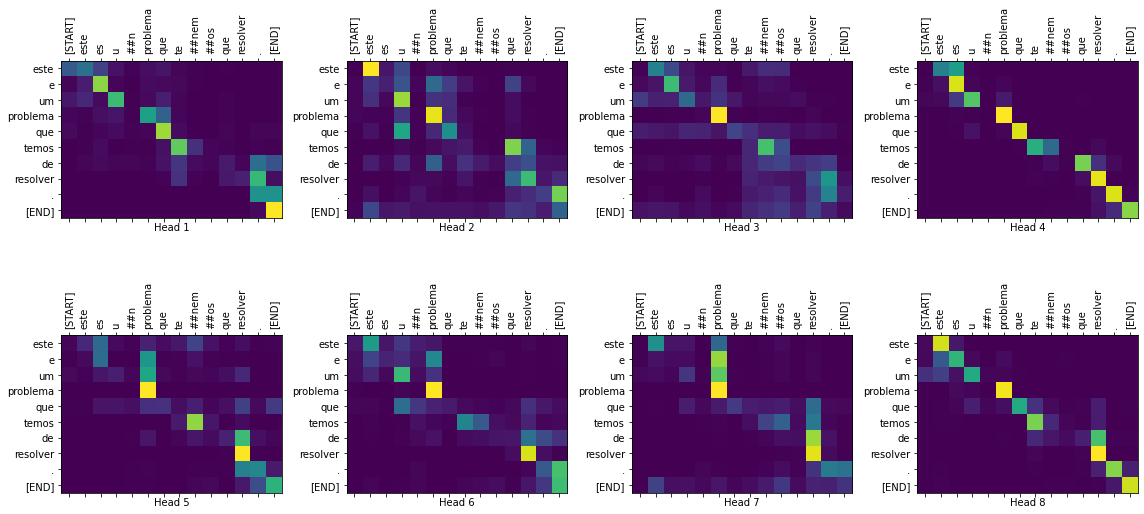

In [79]:
plot_attention_weights(sentence, translated_tokens, attention_weights[0])

In [80]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In [81]:
translator = ExportTranslator(translator)

Ver documentación en: https://github.com/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb